## Helper methods

### Extract multiple-choice answer from response

In [232]:
import re

def extract_answer_letter(response):
    # Match "Resposta final: C)" or "Resposta final: C"
    match = re.search(r"resposta final\s*[:\-]?\s*([A-E])\s*\)?", response, re.IGNORECASE | re.DOTALL)
    if not match:
        # Try fallback patterns
        match = re.search(r"letra\s+([A-E])\b", response, re.IGNORECASE)
    return match.group(1).upper() if match else None

### Calculate overall accuracy of answers

In [233]:
def calculate_accuracy(results):
    """Returns overall accuracy and count of None predictions from a list of result dicts."""
    total_answered = sum(1 for r in results if r["predicted"] is not None)
    correct = sum(r["correct"] for r in results if r["predicted"] is not None)
    total = len(results)
    none_count = total - total_answered
    accuracy = (correct / total_answered) * 100 if total_answered > 0 else 0
    return correct, total_answered, accuracy, none_count

### Group results by subject

In [234]:
import pandas as pd

def results_by_subject(results):
    """Aggregates accuracy grouped by subject"""
    df = pd.DataFrame(results)
    if "subject" not in df.columns:
        print("⚠️ 'subject' not found in results.")
        return None
    
    summary = df.groupby("subject")["correct"].agg(["sum", "count"])
    summary["accuracy (%)"] = (summary["sum"] / summary["count"]) * 100
    return summary

### Save results to csv file

In [235]:
from datetime import datetime
import os

def save_results_csv(df, method_name):
    """
    Save a DataFrame as a CSV file in a 'results/<method_name>' subfolder with a timestamped filename.

    Parameters:
    - df: pandas DataFrame to save
    - method_name: e.g., 'cot', 'cov', 'self-refine'

    Returns:
    - The full filename used
    """
    # Define target folder and create it if needed
    folder = os.path.join("results", method_name)
    os.makedirs(folder, exist_ok=True)

    # Create timestamped filename
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = os.path.join(folder, f"{method_name}_results_{timestamp}.csv")

    # Save the file
    df.to_csv(filename, index=False)
    print(f"✅ Results saved to {filename}")
    return filename

## Chain-of-Thought (CoT) template

In [372]:
def build_cot_prompt(question_obj):
    
    few_shot_examples = """Você verá abaixo alguns exemplos de como a pergunta deve ser respondida passo a passo. Leia atentamente os exemplos e, em seguida, responda a pergunta que vem depois deles.
    
        ### Exemplo 1:
        
        Pergunta:
        Urgência emocional. Se tudo é para ontem, se a vida engata uma primeira e sai em
        disparada, se não há mais tempo para paradas estratégicas, caímos fatalmente no vício de querer
        que os amores sejam igualmente resolvidos num átimo de segundo. Temos pressa para ouvir “eu
        te amo”. Não vemos a hora de que fiquem estabelecidas as regras de convívio: somos namorados,
        ficantes, casados, amantes? Urgência emocional. Uma cilada. Associamos diversas palavras ao
        AMOR: paixão, romance, sexo, adrenalina, palpitação. Esquecemos, no entanto, da palavra que
        viabiliza esse sentimento: “paciência”. Amor sem paciência não vinga. Amor não pode ser mastigado
        e engolido com emergência, com fome desesperada. É uma refeição que pode durar uma vida.
        MEDEIROS, M. Disponível em: http://porumavidasimples.blogspot.com.br. Acesso em: 20 ago. 2017
        (adaptado).   
        
        Nesse texto de opinião, as marcas linguísticas revelam uma situação distensa e de pouca formalidade, o que se evidencia pelo(a)
        
        Opções:
        A) A impessoalização ao longo do texto, com em: “se não há mais tempo”.
        B) A construção de uma atmosfera de urgência, em palavras como: “pressa”.
        C) A repetição de uma determinada estrutura sintática, como em: “Se tudo é para ontem”.
        D) O ênfase no emprego de hipérboles, como em: “uma reflexão que pode durar uma vida”.
        E) O emprego de metáforas, como em: “a vida engata uma primeira e sai em disparada”.
        
        Explicação:
        O texto é escrito em uma linguagem leve, ágil, e de pouca formalidade. Além disso, possui figuras de
        linguagem, como metáforas e hipérboles, que não são excludentes. Em uma análise sequencial das
        alternativas, daria para afirmar que D. e E. estão corretas. Entretanto, observando em detalhes, nota-se
        que a expressão "emprego de metáforas" mostra ser mais adequada do que "ênfase no emprego da
        hipérbole", visto que, para afirmarmos que o uso de hipérboles foi enfatizado, a figura de linguagem
        deveria ter aparecido mais vezes. Isso torna a alternativa E. mais provável de ser CORRETA. Além
        disso, impessoalização não deve ser apontada como marca de pouca formalidade. Existe também uma
        atmosfera de urgência, mas que é criticada no texto que destaca a importância da paciência e não da
        pressa. Por fim, a estrutura sintática não é repetida sistematicamente ao longo do texto.         
        
        Resposta final: E
        
        ---
        
        ### Exemplo 2:
        
        Pergunta:
        Sempre que a relevância do discurso entra em jogo, a questão torna-se política por
        definição, pois é o discurso que faz do homem um ser político. E tudo que os homens fazem, sabem
        ou experimentam só tem sentido na medida em que pode ser discutido. Haverá, talvez, verdades que
        ficam além da linguagem e que podem ser de grande relevância para o homem no singular, isto é, para
        o homem que, seja o que for, não é um ser político. Mas homens no plural, isto é, os homens que vivem
        e se movem e agem neste mundo, só podem experimentar o significado das coisas por poderem falar
        e ser inteligíveis entre si e consigo mesmos. ARENDT, H. A condição humana. Rio de Janeiro: Forense
        Universitária, 2004.
        
        No trecho, a filósofa Hannah Arendt mostra a importância da linguagem no processo de
        
        Opções:
        A) entendimento da cultura.
        B) aumento da criatividade.
        C) percepção da individualidade.
        D) melhoria da técnica.
        E) construção da sociabilidade.
        
        Explicação:
        Hannah Arendt defende em sua obra que somos seres políticos, no sentido próprio de vivermos
        em pólis, em ambiente coletivo e social. E essa sociabilidade só é possível por meio do discurso,
        da linguagem. Desse modo, podemos concluir que a linguagem se apresenta como uma importante
        ferramenta para a construção da sociabilidade, e portanto a alternativa E. é a CORRETA. Além disso,
        não se trata do entendimento da cultura, mas da relação social entre as pessoas dessa cultura. Hannah
        também não fala sobre aumento de criatividade, tampouco sobre técnica. Por fim, a linguagem é
        utilizada em algo mais coletivo e social, justamente o oposto da individualidade.      
        
        Resposta final: E
        
        ---
        
        ### Exemplo 3:
        
        Pergunta:
        Um casal planeja construir em sua chácara uma piscina com o formato de um paralelepípedo reto retângulo com capacidade para 90 000 L de água. O casal contratou uma empresa
        de construções que apresentou cinco projetos com diferentes combinações nas dimensões internas
        de profundidade, largura e comprimento. A piscina a ser construída terá revestimento interno em suas
        paredes e fundo com uma mesma cerâmica, e o casal irá escolher o projeto que exija a menor área de
        revestimento. As dimensões internas de profundidade, largura e comprimento, respectivamente, para
        cada um dos projetos, são: projeto I: 1,8 m, 2,0 m e 25,0 m; projeto II: 2,0 m, 5,0 m e 9,0 m; projeto III:
        1,0 m, 6,0 m e 15,0 m; projeto IV: 1,5 m, 15,0 m e 4,0 m; projeto V: 2,5 m, 3,0 m e 12,0 m.
        
        O projeto que o casal deverá escolher será o
        
        Opções:
        A) I.  
        B) II.  
        C) III.  
        D) IV.  
        E) V.
        
        Explicação:
        Devemos calcular a área das quatro faces laterais e a área da base inferior (fundo da piscina) e somar
        essas áreas para obter a área de revestimento. Logo, calculando a área de revestimento de cada
        projeto, temos: Projeto I: A = 2 x 25 + 2 x 1,8 x (2 + 25) = 147,2; Projeto II: A = 9 x 5 + 2 x 2 x (9 + 5) =
        101; Projeto III: A = 15 x 6 + 2 x 1 x (15 + 6) = 132; Projeto IV: A = 4 x 15 + 2 x 1,5 x (15 + 4) = 117;
        Projeto V: A = 3 x 12 + 2 x 2,5 x (3 + 12) = 111. Logo, o projeto com menor área de revestimento, é o
        projeto II, portanto a resposta corrreta é B.        
        
        Resposta final: B
        
        ---
        
        Agora responda à próxima pergunta seguindo o mesmo formato de raciocício passo a passo.
        """

    # Current question
    question = question_obj["question"]
    options = question_obj["alternatives"]
    option_letters = ["A", "B", "C", "D", "E"]
    formatted_options = "\n".join([f"{letter}) {text}" for letter, text in zip(option_letters, options)])

    prompt = f"""{few_shot_examples}

        Pergunta:
        {question}
        
        Opções:
        {formatted_options}
        
        Explique sua resposta e depois diga a letra da alternativa correta no formato "Resposta final: X"
        """

    return prompt


## Chain-of-Verification (CoVe) template

### Plan verifications

In [303]:
def plan_verification_questions(question, baseline_answer):
    plan_prompt = f"""Dada a seguinte pergunta e resposta, gere 2 a 4 perguntas para verificar os fatos principais da resposta.

Pergunta: {question}

Resposta: {baseline_answer}

Liste as perguntas de verificação:"""
    return call_openai_api(plan_prompt)


### Execute verifications

In [304]:
def execute_verifications(verification_questions):
    verifications = []
    for q in verification_questions:
        answer = call_openai_api(q)
        verifications.append((q, answer))
    return verifications

### Generate final verified answer

In [305]:
def generate_final_verified_answer(question, original_answer, verifications, options=None):
    vtext = "\n".join([f"Q: {q}\nA: {a}" for q, a in verifications])

    option_letters = ["A", "B", "C", "D", "E"]
    options_text = ""
    if options:
        options_text = "\n".join([f"{letter}) {text}" for letter, text in zip(option_letters, options)])

    revise_prompt = f"""
Revise a resposta abaixo com base nas verificações.

Pergunta:
{question}

Alternativas:
{options_text}

Resposta original:
{original_answer}

Verificações:
{vtext}

Resposta final verificada:
[Inclua uma explicação revisada, seguida de uma linha como: "Resposta final: X", onde X é a letra da alternativa correta.]
"""
    return call_openai_api(revise_prompt)


## Self-Refine template

### Give feedback for a previous answer

In [306]:
def build_feedback_prompt(question_obj, model_output):
    question = question_obj["question"]
    options = question_obj["alternatives"]
    option_letters = ["A", "B", "C", "D", "E"]
    formatted_options = "\n".join([f"{l}) {t}" for l, t in zip(option_letters, options)])

    prompt = (
        "Analise a seguinte resposta gerada para uma pergunta do ENEM. "
        "Identifique erros, falhas na argumentação ou escolha incorreta da alternativa. "
        "Aponte aspectos que podem ser melhorados.\n\n"
        f"Pergunta:\n{question}\n\n"
        f"Alternativas:\n{formatted_options}\n\n"
        f"Resposta do modelo:\n{model_output}\n\n"
        "Feedback:"
    )
    return prompt


### Refine response based on feedback

In [307]:
def build_refine_prompt(question_obj, model_output, feedback):
    question = question_obj["question"]
    options = question_obj["alternatives"]
    option_letters = ["A", "B", "C", "D", "E"]
    formatted_options = "\n".join([f"{l}) {t}" for l, t in zip(option_letters, options)])

    prompt = (
        "A seguir está uma pergunta do ENEM, acompanhada de alternativas, "
        "uma resposta inicial e um feedback crítico. Escreva uma nova resposta levando em conta "
        "o feedback, explicando novamente o raciocínio e indicando a letra da alternativa correta "
        "no formato \"Resposta final: X\".\n\n"
        f"Pergunta:\n{question}\n\n"
        f"Alternativas:\n{formatted_options}\n\n"
        f"Resposta anterior:\n{model_output}\n\n"
        f"Feedback:\n{feedback}\n\n"
        "Nova resposta:"
    )
    return prompt


### Feedback iteration wrapper

In [308]:
def self_refine_enem(question_obj, max_iters=3):
    # Generate the initial chain-of-thought response
    prompt = build_cot_prompt(question_obj)
    response = call_openai_api(prompt)
    
    # Extract the final answer from the initial response
    prev_final = extract_answer_letter(response)
    
    history = [(response, None)]

    for _ in range(max_iters):
        # Generate feedback based on the current response
        fb_prompt = build_feedback_prompt(question_obj, response)
        feedback = call_openai_api(fb_prompt)

        # Build the refine prompt using the current response and feedback
        refine_prompt = build_refine_prompt(question_obj, response, feedback)
        new_response = call_openai_api(refine_prompt)
        
        # Extract the final answer from the new response
        new_final = extract_answer_letter(new_response)
        
        # If the final answer is unchanged, exit the loop
        if new_final is not None and new_final == prev_final:
            break
        
        # Update the response and the final answer for the next iteration
        response = new_response
        prev_final = new_final
        history.append((response, feedback))
    
    return response, history

## Load 2024 ENEM questions

In [309]:
import json

# Load the JSONL file line by line
data = []
with open('enem_2024.jsonl', 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Assign subject based on the index (0-indexed)
for i, entry in enumerate(data):
    if i < 45:
        subject = "Linguagens, Códigos e suas Tecnologias"
    elif i < 90:
        subject = "Ciências Humanas e suas Tecnologias"
    elif i < 135:
        subject = "Ciências da Natureza e suas Tecnologias"
    else:
        subject = "Matemática e suas Tecnologias"
    entry["subject"] = subject

# Show the first question
data[0]

{'id': 'questao_01',
 'exam': '2024',
 'IU': False,
 'ledor': False,
 'question': '## Holy War\nOh, so we can hate each other and fear each other\nWe can build these walls between each other Baby, blow by blow and brick by brick Keep yourself locked in, yourself locked in\n[…]\nOh, maybe we should love somebody\nOh, maybe we could care a little more\nSo maybe we should love somebody\nInstead of polishing the bombs of holy war\nNessa letra de canção, de Alicia Keys, que aborda um contexto de ódio e intolerância, o marcador “instead of ” introduz a ideia de',
 'alternatives': ['mudança de comportamento.',
  'panorama de conflitos.',
  'rotina de isolamento.',
  'perspectiva bélica.',
  'cenário religioso.'],
 'label': 'A',
 'figures': [],
 'description': [],
 'subject': 'Linguagens, Códigos e suas Tecnologias'}

## Connect to OpenAI API

In [310]:
from openai import OpenAI

# Read key from file
with open("openai-key.txt", "r") as f:
    api_key = f.read().strip()

client = OpenAI(api_key=api_key)

### API call

In [311]:
def call_openai_api(prompt, model="gpt-3.5-turbo", temperature=0.7):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=temperature
    )
    return response.choices[0].message.content

## Test Prompting Techniques

### Test CoT

#### Test CoT with a single question

In [373]:
q = data[0]
prompt = build_cot_prompt(q)
response = call_openai_api(prompt)
predicted = extract_answer_letter(response)

print("Prompt:\n", prompt)
print("\nModel Response:\n", response)
print(f"\nPredicted: {predicted} | Ground Truth: {q['label']}")


Prompt:
 Você verá abaixo alguns exemplos de como a pergunta deve ser respondida passo a passo. Leia atentamente os exemplos e, em seguida, responda a pergunta que vem depois deles.

        ### Exemplo 1:

        Pergunta:
        Urgência emocional. Se tudo é para ontem, se a vida engata uma primeira e sai em
        disparada, se não há mais tempo para paradas estratégicas, caímos fatalmente no vício de querer
        que os amores sejam igualmente resolvidos num átimo de segundo. Temos pressa para ouvir “eu
        te amo”. Não vemos a hora de que fiquem estabelecidas as regras de convívio: somos namorados,
        ficantes, casados, amantes? Urgência emocional. Uma cilada. Associamos diversas palavras ao
        AMOR: paixão, romance, sexo, adrenalina, palpitação. Esquecemos, no entanto, da palavra que
        viabiliza esse sentimento: “paciência”. Amor sem paciência não vinga. Amor não pode ser mastigado
        e engolido com emergência, com fome desesperada. É uma refeição qu

#### CoT evaluation loop over sample questions

In [374]:
cot_results = []

for i, question in enumerate(data):
    prompt = build_cot_prompt(question)
    correct_answer = question["label"]
    
    try:
        response = call_openai_api(prompt)
        predicted = extract_answer_letter(response)
    except Exception as e:
        response = str(e)
        predicted = None
    
    cot_results.append({
        "id": question["id"],
        "subject": question["subject"],
        "question": question["question"],
        "ground_truth": correct_answer,
        "predicted": predicted,
        "correct": predicted == correct_answer,
        "response": response
    })

    print(f"[{i+1}/{len(data)}] ✅ Predicted: {predicted} | Correct: {correct_answer}")


[1/180] ✅ Predicted: A | Correct: A
[2/180] ✅ Predicted: D | Correct: A
[3/180] ✅ Predicted: C | Correct: C
[4/180] ✅ Predicted: E | Correct: E
[5/180] ✅ Predicted: A | Correct: A
[6/180] ✅ Predicted: C | Correct: C
[7/180] ✅ Predicted: B | Correct: B
[8/180] ✅ Predicted: E | Correct: E
[9/180] ✅ Predicted: A | Correct: D
[10/180] ✅ Predicted: A | Correct: A
[11/180] ✅ Predicted: D | Correct: D
[12/180] ✅ Predicted: E | Correct: E
[13/180] ✅ Predicted: E | Correct: E
[14/180] ✅ Predicted: B | Correct: B
[15/180] ✅ Predicted: D | Correct: D
[16/180] ✅ Predicted: D | Correct: D
[17/180] ✅ Predicted: B | Correct: B
[18/180] ✅ Predicted: D | Correct: D
[19/180] ✅ Predicted: B | Correct: B
[20/180] ✅ Predicted: B | Correct: B
[21/180] ✅ Predicted: D | Correct: C
[22/180] ✅ Predicted: D | Correct: E
[23/180] ✅ Predicted: E | Correct: E
[24/180] ✅ Predicted: B | Correct: C
[25/180] ✅ Predicted: B | Correct: B
[26/180] ✅ Predicted: C | Correct: D
[27/180] ✅ Predicted: C | Correct: C
[28/180] ✅

#### CoT Results

In [376]:
df_cot = pd.DataFrame(cot_results)
save_results_csv(df_cot, method_name="cot_few-shot")
df_cot

✅ Results saved to results/cot_few-shot/cot_few-shot_results_2025-03-27_13-55-58.csv


,id,subject,question,ground_truth,predicted,correct,response
0,questao_01,"Linguagens, Códigos e suas Tecnologias","## Holy War\nOh, so we can hate each other and fear each other\nWe can build these walls between each other Baby, blow by blow and brick by brick Keep yourself locked in, yourself locked in\n[…]\nOh, maybe we should love somebody\nOh, maybe we could care a little more\nSo maybe we should love somebody\nInstead of polishing the bombs of holy war\nNessa letra de canção, de Alicia Keys, que aborda um contexto de ódio e intolerância, o marcador “instead of ” introduz a ideia de",A,A,True,"O marcador ""instead of"" introduz a ideia de substituição ou troca de uma ação por outra. No trecho da letra de Alicia Keys, a ideia é substituir a ação de ""polishing the bombs of holy war"" por ""loving somebody"". Portanto, a ideia introduzida pelo marcador é de mudança de comportamento, escolhendo o amor ao invés da guerra. \n\nResposta final: A) mudança de comportamento."
1,questao_02,"Linguagens, Códigos e suas Tecnologias",[[placeholder]]\nO texto estabelece uma relação entre elementos da natureza e comandos de um programa de computador para,A,D,False,"Para responder a essa pergunta, primeiro vamos analisar o trecho do texto que estabelece a relação entre elementos da natureza e comandos de um programa de computador. Provavelmente, essa relação está sendo utilizada de forma metafórica ou simbólica para transmitir uma mensagem ou ideia.\n\nApós analisar o texto atentamente, podemos concluir que a relação entre elementos da natureza e comandos de um programa de computador está sendo utilizada para **orientar os usuários sobre o emprego sustentável das novas tecnologias**. A associação entre elementos naturais e tecnológicos provavelmente tem o objetivo de destacar a importância da utilização responsável e consciente das novas tecnologias, especialmente no que diz respeito à preservação do meio ambiente.\n\nPortanto, a alternativa correta é:\n\nResposta final: D"
2,questao_03,"Linguagens, Códigos e suas Tecnologias",[[placeholder]]\nA relação entre as citações atribuídas ao físico Albert Einstein e ao cantor e compositor Bob Marley reside na crença de que é necessário,C,C,True,"Para responder a essa pergunta, é necessário analisar as citações atribuídas a Albert Einstein e a Bob Marley, e identificar a semelhança entre elas.\n\nA primeira citação atribuída a Albert Einstein é: ""Em tempos de crise, só a imaginação é mais importante do que o conhecimento"". Isso sugere que em situações difíceis ou adversas, a capacidade de imaginar soluções criativas é essencial.\n\nJá a citação atribuída a Bob Marley é: ""Você nunca sabe como é forte até ser forte é a única escolha que você tem"". Essa frase ressalta a importância de encontrar força interior em momentos de dificuldade extrema.\n\nAmbas as citações destacam a importância de lidar com situações complicadas de forma criativa e resiliente, buscando soluções inovadoras e encontrando força interior para superar desafios.\n\nPortanto, a relação entre as citações de Einstein e Marley reside na crença de que é necessário C) tirar proveito de situações que podem ser adversas.\n\nResposta final: C"
3,questao_04,"Linguagens, Códigos e suas Tecnologias",[[placeholder]]A carta da editora Stephanie Allen-Nichols à escritoraAlice Walker tem o propósito de,E,E,True,"A carta da editora Stephanie Allen-Nichols à escritora Alice Walker tem o propósito de comunicar a recusa da publicação de seu romance. Isso é evidenciado pelo fato de que a editora menciona que o romance não atende aos requisitos necessários para ser publicado e que não é uma história que se encaixa na linha editorial da editora. Portanto, a alternativa correta é a letra E.\n\nResposta final: E"
4,questao_05,"Linguagens, Códigos e suas Tecnologias","## Borderlands/La frontera: the Nem Mestiza\nGlória Anzaldúa\nI remember being caught speaking Spanish at recess [...] I remember being sent to the corner of the classroom for “talking 

### Test CoVe

#### Test CoVe with a single question

In [377]:
# Step 1: Pick a question
q = data[0]
question_text = q["question"]
prompt = build_cot_prompt(q)

# Step 2: Baseline CoT answer
baseline_answer = call_openai_api(prompt)

print("🔹 Baseline CoT Answer:\n", baseline_answer)

# Step 3: Plan verification questions
verification_qs_raw = plan_verification_questions(question_text, baseline_answer)

# Split the response into individual questions if the model gives a list
verification_questions = [line.strip("- ").strip() for line in verification_qs_raw.split("\n") if line.strip()]

print("\n🔹 Verification Questions:")
for qv in verification_questions:
    print("-", qv)

# Step 4: Execute verification
verifications = execute_verifications(verification_questions)

print("\n🔹 Verification Answers:")
for qv, av in verifications:
    print(f"Q: {qv}\nA: {av}\n")

# Step 5: Generate final verified answer
final_answer = generate_final_verified_answer(question_text, baseline_answer, verifications)

print("🔹 Final Verified Answer:\n", final_answer)

# Step 6: Extract predicted letter and compare to ground truth
predicted = extract_answer_letter(final_answer)
ground_truth = q["label"]

print(f"\n✅ Predicted Answer: {predicted}")
print(f"🎯 Ground Truth: {ground_truth}")

if predicted == ground_truth:
    print("🎉 CORRECT!")
else:
    print("❌ WRONG.")


🔹 Baseline CoT Answer:
 A expressão "instead of" introduz a ideia de substituição ou troca de uma ação por outra. No contexto da letra da música, a ideia é substituir o ato de "polishing the bombs of holy war" por algo mais positivo, como amar alguém. Portanto, a expressão "instead of" introduz a ideia de mudança de comportamento.

Resposta final: A

🔹 Verification Questions:
- 1. Qual é o contexto da letra de música citada?
- 2. O que a expressão "instead of" introduz na ideia transmitida pela música?
- 3. Qual é a sugestão feita pela música em relação ao comportamento humano?
- 4. Como a música aborda a questão da intolerância e do ódio?

🔹 Verification Answers:
Q: 1. Qual é o contexto da letra de música citada?
A: Desculpe, mas você não forneceu a letra da música citada. Você poderia fornecer mais informações ou a letra da música para que eu possa ajudá-lo a entender o contexto?

Q: 2. O que a expressão "instead of" introduz na ideia transmitida pela música?
A: A expressão "instead 

#### CoVe evaluation loop over sample questions

In [378]:
cove_results = []

for i, question in enumerate(data):
    try:
        question_text = question["question"]
        correct_answer = question["label"]

        # Build CoT-style prompt
        prompt = build_cot_prompt(question)

        # Baseline CoT response
        baseline_answer = call_openai_api(prompt)

        # Extract initial answer letter from baseline
        initial_answer_letter = extract_answer_letter(baseline_answer)

        # Plan verifications
        verification_qs_raw = plan_verification_questions(question_text, baseline_answer)
        verification_questions = [line.strip("- ").strip() for line in verification_qs_raw.split("\n") if line.strip()]

        # Execute verifications
        verifications = execute_verifications(verification_questions)

        # Final revised answer
        final_answer = generate_final_verified_answer(
            question_text, baseline_answer, verifications, question["alternatives"]
        )

        # Extract answer letter (A–E)
        predicted = extract_answer_letter(final_answer)

        # Record result
        cove_results.append({
            "id": question["id"],
            "question": question_text,
            "ground_truth": correct_answer,
            "predicted": predicted,
            "correct": predicted == correct_answer,
            "baseline_answer": baseline_answer,
            "initial_answer": initial_answer_letter,
            "final_answer": final_answer,
            "verification_qs": verification_questions,
            "verification_a": verifications,
            "subject": question.get("subject", "unknown")
        })

        print(f"[{i+1}/{len(data)}] ✅ Predicted: {predicted} | Correct: {correct_answer}")

    except Exception as e:
        print(f"[{i+1}/{len(data)}] ❌ Error: {e}")
        cove_results.append({
            "index": i,
            "question": question_text,
            "true_answer": correct_answer,
            "predicted": None,
            "correct": False,
            "error": str(e)
        })


[1/180] ✅ Predicted: A | Correct: A
[2/180] ✅ Predicted: D | Correct: A
[3/180] ✅ Predicted: C | Correct: C
[4/180] ✅ Predicted: D | Correct: E
[5/180] ✅ Predicted: A | Correct: A
[6/180] ✅ Predicted: C | Correct: C
[7/180] ✅ Predicted: B | Correct: B
[8/180] ✅ Predicted: E | Correct: E
[9/180] ✅ Predicted: A | Correct: D
[10/180] ✅ Predicted: A | Correct: A
[11/180] ✅ Predicted: D | Correct: D
[12/180] ✅ Predicted: E | Correct: E
[13/180] ✅ Predicted: E | Correct: E
[14/180] ✅ Predicted: B | Correct: B
[15/180] ✅ Predicted: D | Correct: D
[16/180] ✅ Predicted: D | Correct: D
[17/180] ✅ Predicted: B | Correct: B
[18/180] ✅ Predicted: D | Correct: D
[19/180] ✅ Predicted: B | Correct: B
[20/180] ✅ Predicted: B | Correct: B
[21/180] ✅ Predicted: D | Correct: C
[22/180] ✅ Predicted: A | Correct: E
[23/180] ✅ Predicted: E | Correct: E
[24/180] ✅ Predicted: B | Correct: C
[25/180] ✅ Predicted: B | Correct: B
[26/180] ✅ Predicted: D | Correct: D
[27/180] ✅ Predicted: C | Correct: C
[28/180] ✅

#### CoVe results

In [379]:
df_cove = pd.DataFrame(cove_results)
save_results_csv(df_cove, method_name="cove_few-shot")
df_cove

✅ Results saved to results/cove_few-shot/cove_few-shot_results_2025-03-27_14-42-13.csv


,id,question,ground_truth,predicted,correct,baseline_answer,initial_answer,final_answer,verification_qs,verification_a,subject
0,questao_01,"## Holy War\nOh, so we can hate each other and fear each other\nWe can build these walls between each other Baby, blow by blow and brick by brick Keep yourself locked in, yourself locked in\n[…]\nOh, maybe we should love somebody\nOh, maybe we could care a little more\nSo maybe we should love somebody\nInstead of polishing the bombs of holy war\nNessa letra de canção, de Alicia Keys, que aborda um contexto de ódio e intolerância, o marcador “instead of ” introduz a ideia de",A,A,True,"A expressão ""instead of"" introduz a ideia de substituição ou troca de uma ação por outra. No contexto da letra da canção, em que se fala sobre ódio e intolerância, a sugestão é de que ao invés de alimentar a guerra santa, deveríamos amar alguém. Portanto, a ideia introduzida por ""instead of"" é de mudança de comportamento, escolhendo o amor em vez do conflito.\n\nResposta final: A",A,"A expressão ""instead of"" é utilizada na letra da canção para introduzir a ideia de substituição de uma ação por outra. No contexto abordado, a sugestão é de que ao invés de alimentar a guerra santa, deveríamos amar alguém. Portanto, a ideia introduzida por ""instead of"" é de mudança de comportamento, escolhendo o amor em vez do conflito.\n\nResposta final: A","[1. Qual a mensagem principal da letra da canção de Alicia Keys abordada na pergunta?, 2. Como a expressão ""instead of"" é utilizada na letra da canção em relação à ideia de ódio e intolerância?, 3. Qual a sugestão feita pela cantora Alicia Keys em relação ao comportamento das pessoas no contexto da música?, 4. Como a ideia de substituição ou troca de ação é representada na letra da canção em relação à guerra santa?]","[(1. Qual a mensagem principal da letra da canção de Alicia Keys abordada na pergunta?, A mensagem principal da letra da canção de Alicia Keys abordada na pergunta é a importância de valorizar a própria individualidade, autoestima e autoaceitação, sem se deixar influenciar pelas expectativas e padrões externos. A letra ressalta a beleza e força de cada pessoa, independentemente de sua aparência física ou de outros aspectos superficiais.), (2. Como a expressão ""instead of"" é utilizada na letra da canção em relação à ideia de ódio e intolerância?, Na letra da canção, a expressão ""instead of"" é utilizada para contrastar a ideia de ódio e intolerância com a ideia de amor e compreensão. A letra sugere que em vez de alimentar o ódio e a intolerância, as pessoas deveriam escolher o amor e a compreensão como forma de resolver conflitos e promover a paz. A expressão ""instead of"" é usada para mostrar uma alternativa positiva e construtiva em oposição à negatividade do ódio e da intolerância.), (3. Qual a sugestão feita pela cantora Alicia Keys em relação ao comportamento das pessoas no contexto da música?, A sugestão feita pela cantora Alicia Keys é que as pessoas devem parar de julgar e criticar os artistas e músicos, e em vez disso, apreciar a música e a arte que eles produzem. Ela argumenta que a música é uma forma de expressão pessoal e criativa, e que todos devem ser capazes de se expressar livremente sem medo de julgamentos. Keys também enfatiza a importância de valorizar a diversidade e a individualidade na música, e de celebrar as diferentes vozes e perspectivas que ela oferece.), (4. Como a ideia de substituição ou troca de ação é representada na letra da canção em relação à guerra santa?, Na letra da canção, a ideia de substituição ou troca de ação é representada através da narrativa de um soldado que questiona seu papel na guerra santa e se sente desiludido com a violência e destruição que ela traz. Ele se pergunta se vale a pena continuar lutando e se há uma alternativa ou outra maneira de resolver os conflitos sem recorrer à violência. Essa reflexão sugere a possibilidade de substituir a guerra santa por ações mais pacíficas e construtivas, 

### Test Self-Refine

#### Test Self-Refine with a single question 

In [380]:
q = data[0]
final_response, trace = self_refine_enem(q)
predicted = extract_answer_letter(final_response)

print("Prompt inicial (iteração 0):\n", build_cot_prompt(q))
print("\nResposta final após refinamento:\n", final_response)
print(f"\nAlternativa prevista: {predicted} | Gabarito: {q['label']}")

print("\nHistórico de iterações:")
for i, (resp, fb) in enumerate(trace):
    print(f"\n--- Iteração {i} ---")
    print("Resposta:", resp)
    if fb:
        print("Feedback:", fb)


Prompt inicial (iteração 0):
 Você verá abaixo alguns exemplos de como a pergunta deve ser respondida passo a passo. Leia atentamente os exemplos e, em seguida, responda a pergunta que vem depois deles.

        ### Exemplo 1:

        Pergunta:
        Urgência emocional. Se tudo é para ontem, se a vida engata uma primeira e sai em
        disparada, se não há mais tempo para paradas estratégicas, caímos fatalmente no vício de querer
        que os amores sejam igualmente resolvidos num átimo de segundo. Temos pressa para ouvir “eu
        te amo”. Não vemos a hora de que fiquem estabelecidas as regras de convívio: somos namorados,
        ficantes, casados, amantes? Urgência emocional. Uma cilada. Associamos diversas palavras ao
        AMOR: paixão, romance, sexo, adrenalina, palpitação. Esquecemos, no entanto, da palavra que
        viabiliza esse sentimento: “paciência”. Amor sem paciência não vinga. Amor não pode ser mastigado
        e engolido com emergência, com fome desespera

#### Self-Refine evaluation loop over sample questions

In [381]:
self_refine_results = []

for i, question in enumerate(data):
    try:
        question_text = question["question"]
        correct_answer = question["label"]

        # 1. Run SELF-REFINE
        final_answer, trace = self_refine_enem(question, max_iters=3)
        predicted = extract_answer_letter(final_answer)

        # 2. Extract intermediate answers from trace
        answer_sequence = []
        baseline_answer = None
        
        for step, (response, feedback) in enumerate(trace):
            try:
                letter = extract_answer_letter(response)
            except Exception:
                letter = None
            answer_sequence.append(letter)
            if step == 0:
                baseline_answer = response

        # 3. Record result
        self_refine_results.append({
            "id": question["id"],
            "question": question_text,
            "ground_truth": correct_answer,
            "predicted": predicted,
            "correct": predicted == correct_answer,
            "baseline_answer": baseline_answer,
            "final_answer": final_answer,
            "answer_sequence": answer_sequence, 
            "trace": trace,
            "subject": question.get("subject", "unknown")
        })

        print(f"[{i+1}/{len(data)}] ✅ Predicted: {predicted} | Correct: {correct_answer}")

    except Exception as e:
        print(f"[{i+1}/{len(data)}] ❌ Error: {e}")
        self_refine_results.append({
            "index": i,
            "question": question.get("question", ""),
            "true_answer": question.get("label", ""),
            "predicted": None,
            "correct": False,
            "error": str(e),
            "subject": question.get("subject", "unknown")
        })


[1/180] ✅ Predicted: A | Correct: A
[2/180] ✅ Predicted: D | Correct: A
[3/180] ✅ Predicted: C | Correct: C
[4/180] ✅ Predicted: E | Correct: E
[5/180] ✅ Predicted: A | Correct: A
[6/180] ✅ Predicted: C | Correct: C
[7/180] ✅ Predicted: B | Correct: B
[8/180] ✅ Predicted: E | Correct: E
[9/180] ✅ Predicted: A | Correct: D
[10/180] ✅ Predicted: A | Correct: A
[11/180] ✅ Predicted: D | Correct: D
[12/180] ✅ Predicted: E | Correct: E
[13/180] ✅ Predicted: E | Correct: E
[14/180] ✅ Predicted: B | Correct: B
[15/180] ✅ Predicted: D | Correct: D
[16/180] ✅ Predicted: D | Correct: D
[17/180] ✅ Predicted: A | Correct: B
[18/180] ✅ Predicted: D | Correct: D
[19/180] ✅ Predicted: B | Correct: B
[20/180] ✅ Predicted: B | Correct: B
[21/180] ✅ Predicted: E | Correct: C
[22/180] ✅ Predicted: A | Correct: E
[23/180] ✅ Predicted: E | Correct: E
[24/180] ✅ Predicted: B | Correct: C
[25/180] ✅ Predicted: B | Correct: B
[26/180] ✅ Predicted: C | Correct: D
[27/180] ✅ Predicted: C | Correct: C
[28/180] ✅

#### Self-Refine Results

In [382]:
df_self_refine = pd.DataFrame(self_refine_results)
save_results_csv(df_self_refine, method_name="self-refine_few-shot")
df_self_refine

✅ Results saved to results/self-refine_few-shot/self-refine_few-shot_results_2025-03-27_15-08-17.csv


id  \
0     questao_01   
1     questao_02   
2     questao_03   
3     questao_04   
4     questao_01   
..           ...   
361  questao_176   
362  questao_177   
363  questao_178   
364  questao_179   
365  questao_180   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 question  \
0                                                                                                                                                                                                                                                                                                                                                                          ## Holy War\nOh, so we can hate each other and fear each other\nWe can build these walls between each other Baby, blow by blow and brick by brick Keep yourself locked in, yourself locked in\n[…]\nOh, maybe we should love somebody\nOh, maybe we could care a little more\nSo maybe we should love somebody\nInstead of polishing the bombs of holy war\nNessa letra de canção, de Alicia Keys, que aborda um contexto de ódio e intolerância, o marcador “instead of ” introduz a ideia de   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [[placeholder]]\nO texto estabelece uma relação entre elementos da natureza e comandos de um programa de computador para   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              [[placeholder]]\nA relação entre as citações atribuídas ao físico Albert Einstein e ao cantor e compositor Bob Marley reside na crença de que é necessário   
3                                                                                                                                                                                                                                                                                                                                                                                                        

## Analyse Results 

### Overall accuracy 

In [326]:
def compute_summary(df, method_name):
    total = len(df)
    correct = df['correct'].sum()
    accuracy = correct / total
    return {
        'Method': method_name,
        'Total Questions': total,
        'Correct': correct,
        'Accuracy (%)': round(accuracy * 100, 2)
    }    

In [327]:
overall = pd.DataFrame([
    compute_summary(df_cot, "CoT"),
    compute_summary(df_cove, "CoVe"),
    compute_summary(df_self_refine, "SELF-REFINE")
])

print(overall)

        Method  Total Questions  Correct  Accuracy (%)
0          CoT              180      126         70.00
1         CoVe              180      123         68.33
2  SELF-REFINE              186      124         66.67


### Subject-wise accuracy

In [328]:
def subject_accuracy(df, method_name):
    grouped = df.groupby("subject")["correct"].agg(["count", "sum"])
    grouped["Accuracy (%)"] = round(grouped["sum"] / grouped["count"] * 100, 2)
    grouped["Method"] = method_name
    return grouped.reset_index()[["subject", "Method", "Accuracy (%)"]]

In [329]:
subject_cot = subject_accuracy(df_cot, "CoT")
subject_cove = subject_accuracy(df_cove, "CoVe")
subject_self = subject_accuracy(df_self_refine, "SELF-REFINE")

subject_summary = pd.concat([subject_cot, subject_cove, subject_self], ignore_index=True)

print(subject_summary)

                                    subject       Method  Accuracy (%)
0       Ciências Humanas e suas Tecnologias          CoT         93.33
1   Ciências da Natureza e suas Tecnologias          CoT         55.56
2    Linguagens, Códigos e suas Tecnologias          CoT         75.56
3             Matemática e suas Tecnologias          CoT         55.56
4       Ciências Humanas e suas Tecnologias         CoVe         91.11
5   Ciências da Natureza e suas Tecnologias         CoVe         57.78
6    Linguagens, Códigos e suas Tecnologias         CoVe         75.56
7             Matemática e suas Tecnologias         CoVe         48.89
8       Ciências Humanas e suas Tecnologias  SELF-REFINE         88.89
9   Ciências da Natureza e suas Tecnologias  SELF-REFINE         57.78
10   Linguagens, Códigos e suas Tecnologias  SELF-REFINE         74.51
11            Matemática e suas Tecnologias  SELF-REFINE         44.44


#### Visualize results

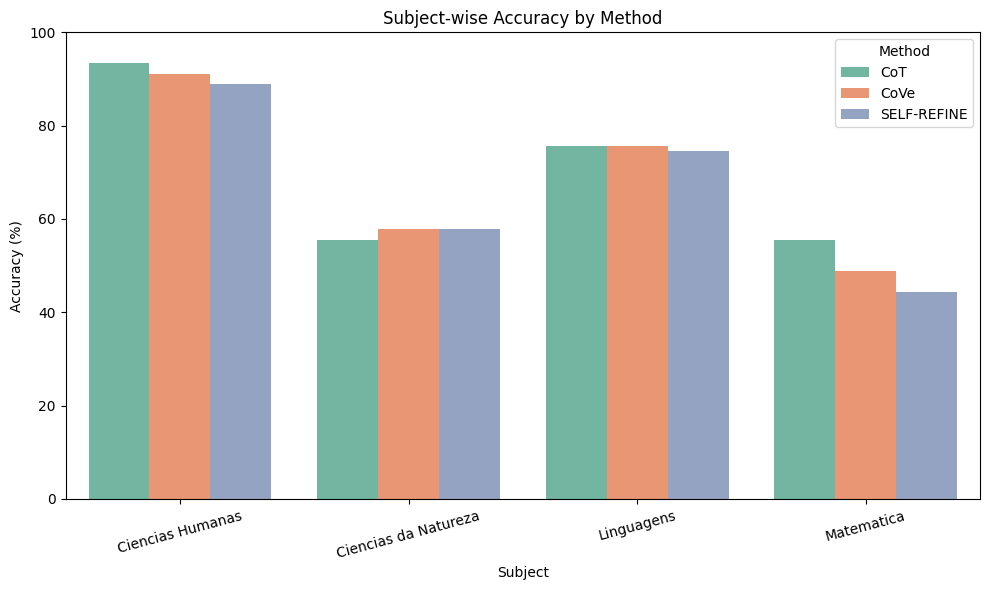

In [330]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rename subjects for clarity in the plot
subject_summary["subject"] = subject_summary["subject"].replace({
    "Linguagens, Códigos e suas Tecnologias": "Linguagens",
    "Ciências da Natureza e suas Tecnologias": "Ciencias da Natureza",
    "Ciências Humanas e suas Tecnologias": "Ciencias Humanas",
    "Matemática e suas Tecnologias": "Matematica"
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=subject_summary,
    x="subject",
    y="Accuracy (%)",
    hue="Method",
    palette="Set2"
)

plt.title("Subject-wise Accuracy by Method")
plt.ylabel("Accuracy (%)")
plt.xlabel("Subject")
plt.ylim(0, 100)
plt.xticks(rotation=15)
plt.legend(title="Method")
plt.tight_layout()
plt.show()


### Regressions: Model changed a correct answer to a wrong one


#### CoVe

In [347]:
if "initial_answer" not in df_cove.columns:
    df_cove["initial_answer"] = df_cove["baseline_answer"].apply(extract_answer_letter)

regressions_cove = df_cove[
    (df_cove["initial_answer"] == df_cove["ground_truth"]) &
    (df_cove["predicted"] != df_cove["ground_truth"])
]

In [353]:
total_cove = len(df_cove)
n_regressions_cove = len(regressions_cove)
print(f"Regressions in CoVe: {n_regressions_cove} out of {total_cove} ({n_regressions_cove/total_cove:.2%})")

Regressions in CoVe: 9 out of 180 (5.00%)


In [348]:
for _, row in regressions_cove.iterrows():
    print(f"ID: {row['id']}, Initial: {row['initial_answer']} ✅, Final: {row['predicted']} ❌")
    print(f"Q: {row['question']}")
    print(f"Baseline Answer:\n{row['baseline_answer']}")
    print("-" * 25)
    print(f"Final Answer:\n{row['final_answer']}")
    print("-" * 50)


ID: questao_05, Initial: A ✅, Final: C ❌
Q: ## Borderlands/La frontera: the Nem Mestiza
Glória Anzaldúa
I remember being caught speaking Spanish at recess [...] I remember being sent to the corner of the classroom for “talking back” to the Anglo teacher when all I was trying to do was tell her how to pronounce my name. “If you want to be American, speak ‘American’. If you don’t like it, go back to Mexico where you belong”.
“I want you to speak English […]”, my mother would say, mortified that I spoke English like a Mexican. At Pan American University, I and all Chicano students were required to take two speech classes. Their purpose: to get rid of our accents.
O problema abordado nesse texto sobre imigrantes residentes nos Estados Unidos diz respeito aos prejuízos gerados pelo(a)
Baseline Answer:
Para responder a essa pergunta, é importante analisar o trecho do texto fornecido. Nele, a autora relata experiências em que foi repreendida por falar espanhol e por não falar inglês corretame

#### Self-Refine

In [364]:
df_self_refine["initial_answer"] = df_self_refine["answer_sequence"].apply(lambda seq: seq[0] if seq and len(seq) > 0 else None)

regressions_self_refine = df_self_refine[
    (df_self_refine["initial_answer"] == df_self_refine["ground_truth"]) &
    (df_self_refine["predicted"] != df_self_refine["ground_truth"])
]


In [365]:
total_self_refine = len(df_self_refine)
n_regressions_self_refine = len(regressions_self_refine)
print(f"Regressions in Self-Refine: {n_regressions_self_refine} out of {total_self_refine} ({n_regressions_self_refine/total_self_refine:.2%})")

Regressions in Self-Refine: 11 out of 186 (5.91%)


In [366]:
for _, row in regressions_self_refine.iterrows():
    print(f"ID: {row['id']}, Initial: {row['initial_answer']} ✅, Final: {row['predicted']} ❌")
    print(f"Q: {row['question']}")
    print(f"Baseline Answer:\n{row['baseline_answer']}")
    print("-" * 25)
    print(f"Final Answer:\n{row['final_answer']}")
    print("-" * 50)

ID: questao_06, Initial: C ✅, Final: D ❌
Q: ## Se você é feito de música, este texto é pra você
Às vezes, no silêncio da noite, eu fico imaginando: que graça teria a vida sem música? Sem ela não há paz, não há beleza. Nos dias de festa e nas madrugadas de pranto, nas trilhas dos filmes e nas corridas no parque, o que seria de nós sem as canções que enfeitam o cotidiano com ritmo e verso? Quem nunca curou uma dor de cotovelo dançando lambada ou terminou de se afundar ouvindo sertanejo sofrência? Quantos já criticaram funk e fecharam a noite descendo até o chão? Tudo bem... Raul nos ensinou que é preferível ser essa metamorfose ambulante do que ter aquela velha opinião formada sobre tudo.
Já somos castigados com o peso das tragédias, o barulho das buzinas, os ruídos dos conflitos. É pau, é pedra, é o fim do caminho. Há uma nuvem de lágrimas sobre os olhos, você está na lanterna dos afogados, o coração despedaçado. Mas, como um sopro, da janela do vizinho, entra o samba que reanima a ment

### Improvements: Model fixed its answer

#### CoVe

In [367]:
improvements_cove = df_cove[
    (df_cove["initial_answer"] != df_cove["ground_truth"]) &
    (df_cove["predicted"] == df_cove["ground_truth"])
]

total_cove = len(df_cove)
n_improvements_cove = len(improvements_cove)
print(f"Improvements in CoVe: {n_improvements_cove} out of {total_cove} ({n_improvements_cove/total_cove:.2%})")

Improvements in CoVe: 4 out of 180 (2.22%)


In [368]:
for _, row in improvements_cove.iterrows():
    print(f"ID: {row['id']}, Initial: {row['initial_answer']} ❌, Final: {row['predicted']} ✅")
    print(f"Q: {row['question']}")
    print(f"Baseline:\n{row['baseline_answer']}")
    print(f"Final:\n{row['final_answer']}")
    print("-" * 50)

ID: questao_02, Initial: D ❌, Final: A ✅
Q: [[placeholder]]
O texto estabelece uma relação entre elementos da natureza e comandos de um programa de computador para
Baseline:
Para responder a essa pergunta, primeiro vamos analisar a relação estabelecida no texto entre elementos da natureza e comandos de um programa de computador. O texto menciona que a natureza "não aceita comandos de acelerar" e que "a natureza não recebe comandos para crescer mais rápido". Isso sugere que o texto está comparando a capacidade de controle e manipulação de um programa de computador com a natureza, destacando a diferença entre a intervenção humana e os processos naturais.

Com base nessa análise, podemos concluir que o objetivo do texto não é alertar sobre a destruição da natureza (opção A), conscientizar sobre a passagem do tempo (opção B), apresentar avanços tecnológicos na agricultura (opção C), orientar sobre o emprego sustentável de novas tecnologias (opção D) ou informar sobre o tempo de crescimento

#### Self-Refine

In [370]:
improvements_self_refine = df_self_refine[
    (df_self_refine["initial_answer"] != df_self_refine["ground_truth"]) &
    (df_self_refine["predicted"] == df_self_refine["ground_truth"])
]

total_self = len(df_self_refine)
n_improvements_self_refine = len(improvements_self_refine)
print(f"Improvements in Self-Refine: {n_improvements_self_refine} out of {total_self} ({n_improvements_self_refine/total_self:.2%})")

Improvements in Self-Refine: 4 out of 186 (2.15%)


In [371]:
for _, row in improvements_self_refine.iterrows():
    print(f"ID: {row['id']}, Initial: {row['initial_answer']} ❌, Final: {row['predicted']} ✅")
    print(f"Q: {row['question']}")
    print(f"Baseline:\n{row['baseline_answer']}")
    print(f"Final:\n{row['final_answer']}")
    print("-" * 50)

ID: questao_28, Initial: E ❌, Final: B ✅
Q: Esaú e Jacó
Machado de Assis Capítulo 48/ Terpsícore
Ao contrário do que ficou dito atrás, Flora não se aborreceu na ilha. Conjeturei mal, emendo-me a tempo. Podia aborrecer-se pelas razões que lá ficam, e ainda outras que poupei ao leitor apressado; mas, em verdade, passou bem a noite. A novidade da festa, a vizinhança do mar, os navios perdidos na sombra, a cidade defronte com os seus lampiões de gás, embaixo e em cima, na praia e nos outeiros, eis aí aspectos novos que a encantaram durante aquelas horas rápidas.
Não lhe faltavam pares, nem conversação, nem alegria alheia e própria. Toda ela compartia da felicidade dos outros. Via, ouvia, sorria, esquecia-se do resto para se meter consigo. Também invejava a princesa imperial, que viria a ser imperatriz um dia, com o absoluto poder de despedir ministros e damas, visitas e requerentes, e ficar só, no mais recôndito do paço, fartando-se de contemplação ou de música. Era assim que Flora definia